In [1]:
import torch as t
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
from skimage import color
from skimage.io import imshow
from tqdm.notebook import tqdm
from torchvision import transforms
%matplotlib inline

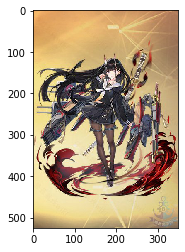

In [2]:
raw_img = Image.open("./noshiro.jpg")
width, height = raw_img.width, raw_img.height
plt.imshow(raw_img)

(<matplotlib.image.AxesImage at 0x290bc4cd388>, (256, 256, 3))

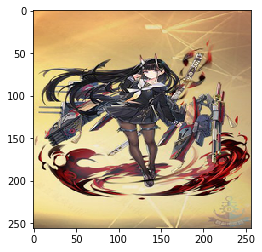

In [3]:
img_rgb = np.array(raw_img.resize((256,256),Image.ANTIALIAS))
plt.imshow(img_rgb),img_rgb.shape

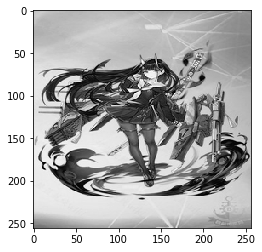

In [6]:
img_lab = color.rgb2lab(img_rgb)
plt.imshow(img_lab[:,:,0],cmap = 'gray')

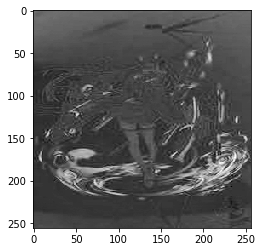

In [7]:
plt.imshow(img_lab[:,:,1],cmap = 'gray') # matplotlib没有专门绘制ab通道的cmap，所以这里只是个示意图，真实色彩不是这样的。

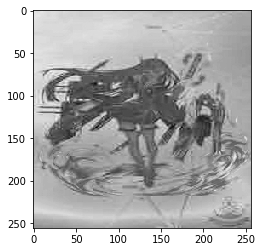

In [8]:
plt.imshow(img_lab[:,:,2],cmap = 'gray') # matplotlib没有专门绘制ab通道的cmap，所以这里只是个示意图，真实色彩不是这样的。

In [9]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [10]:
x_train = img_lab[:,:,0]
y_train = img_lab[:,:,1:3]
y_train /= 128

In [11]:
x_train.shape, y_train.shape

((256, 256), (256, 256, 2))

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [14]:
x_train,y_train = transform(x_train),transform(y_train)
x_train,y_train = x_train.float(),y_train.float()
x_train,y_train = x_train.view(-1,1,256,256),y_train.view(-1,2,256,256)
x_train,y_train = x_train.to(device),y_train.to(device)

In [15]:
x_train.shape,y_train.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 2, 256, 256]))

In [16]:
class Net(t.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = t.nn.Sequential(
            t.nn.Conv2d(1,16,3,stride=2,padding=1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv2 = t.nn.Sequential(
            t.nn.Conv2d(16,32,3,2,1),
            t.nn.BatchNorm2d(32),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv3 = t.nn.Sequential(
            t.nn.Conv2d(32,16,3,2,1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv4 = t.nn.Sequential(
            t.nn.Conv2d(16,2,3,2,1),
            t.nn.BatchNorm2d(2),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [17]:
EPOCHS = 500
LR = 0.01
net = Net().to(device)
criterion = t.nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=LR,weight_decay=0.0)

In [18]:
for epoch in tqdm(range(EPOCHS)):
    index=0
    if epoch % 100 == 0:
        for param_group in optimizer.param_groups:
            LR = LR * 0.9
            param_group['lr'] = LR
    prediction = net.forward(x_train)
    loss = criterion(prediction,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
loss

tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)

In [19]:
net.eval()
prediction = net.forward(x_train).cpu()
prediction *= 128

In [20]:
prediction = prediction[0].data.numpy()
x_train = x_train.cpu()
x_train = x_train[0].data.numpy()
x_train.shape,prediction.shape

((1, 256, 256), (2, 256, 256))

In [21]:
result = np.zeros((256,256,3))
result[:,:,0] = x_train[0]
result[:,:,1] = prediction[0]
result[:,:,2] = prediction[1]

In [22]:
result_rgb = color.lab2rgb(result)

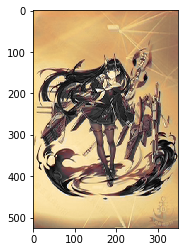

In [23]:
output = Image.fromarray(np.uint8(result_rgb*255))
output = output.resize((width, height),Image.ANTIALIAS)
plt.imshow(output)

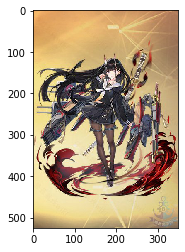

In [24]:
plt.imshow(raw_img)

In [25]:
output.save("output.jpg")